# Installation of the requiered libraries and imports



In [ ]:
### INSTALLATION
#!pip install --upgrade tqdm gcsfs zarr dask xarray scipy datetime pyproj #Originale
!pip install --upgrade pyyaml==5.4.1 tqdm gcsfs zarr dask xarray scipy datetime pyproj

In [ ]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da

import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
# OPEN DATASET
fs     = gcsfs.GCSFileSystem(project='ds2class-2021', token='anon', access='read_only')
gcsmap = fs.get_mapper("project10_tc_sar/zarr_data/tc_sar_data.zarr")
ds_all = xr.open_zarr(gcsmap)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

# **Spatial and temporal coverage of the TCs**

In [ ]:
#Information necessary for the plot.
lon=ds_all["lon"].values
lat=ds_all["lat"].values
lon=lon[:,499,499]
lat=lat[:,499,499]
cat=ds_all["cat"].values
names=ds_all["storm_name"].values

In [ ]:
#Projection of the longitude and latitude in the mercartor coordinates system.
from pyproj import transform,Proj
X,Y=transform(Proj('epsg:4326'),Proj('epsg:3857'),lat,lon)

In [ ]:
from bokeh.io import output_notebook #Bokeh is a library that allows interactive plots.
from bokeh.plotting import figure, output_file, show,save
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import Circle, ColumnDataSource, Grid, LinearAxis, Plot,PanTool,WheelZoomTool,HoverTool,ResetTool

output_notebook()

col={0:"green",1:"blue",2:"yellow",3:"orange",4:"red",5:"black"} #Allows us to choose the color for each category.
source = ColumnDataSource(dict(x=X, y=Y, colors=[col[i] for i in cat],cat=["Category "+str(i) for i in cat],names=names,cat_num=cat,lon=lon,lat=lat))

tools = [PanTool(),WheelZoomTool(),ResetTool(),HoverTool(tooltips=[('Name,Category,Lon,Lat', "@names ,@cat_num ,@lon ° ,@lat ° ")],line_policy='nearest',mode='vline')] 

plot = figure(x_range=(-20037508.34, 20037508.34), y_range=(-1000000, 5000000),
           x_axis_type="mercator", y_axis_type="mercator",title="Repartition of the cyclones",tools=tools, plot_width=1000, plot_height=500)

plot.toolbar.active_scroll = plot.select_one(WheelZoomTool)

tile_provider = get_provider(CARTODBPOSITRON)#Choice of the map.
plot.add_tile(tile_provider)

plot.title.text_font_size = '20pt'
plot.title.align="center"

plot.circle(x="x", y="y", fill_color="colors",source=source,legend_group="cat",size=10)
plot.legend.label_text_font_size = "7pt"
plot.legend.background_fill_alpha = 0.0
plot.legend.border_line_alpha = 0.0

#output_file("map_cyclones.html") # To export in an html file
show(plot)

#output_file("map.html")
#save(plot)


#**Mean wind field by Saffir-Simpson category**

## *First Method: without normalisation nor polar projection*


In [ ]:
### GROUP DATASET BY CATEGORY
ds=ds_all[["cat","lon","lat","wind_speed"]]
WS={}
WS_std={}
for cat, ds_cat in tqdm(ds.groupby('cat')):
    WS[cat]=ds_cat.mean(dim="time",skipna=True)["wind_speed"].values
    WS_std[cat]=ds_cat.std(dim="time",skipna=True)["wind_speed"].values
    #print('Cat. %i ='%cat, ds_cat.dims['time'])

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
 17%|█▋        | 1/6 [00:13<01:08, 13.75s/it]/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
 33%|███▎      | 2/6 [00:26<00:52, 13.09s/it]/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
 50%|█████     | 3/6 [00:32<00:30, 10.09s/it]/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
 67%|██████▋   | 4/6 [00:41<00:19,  9.53s/it]/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
 83

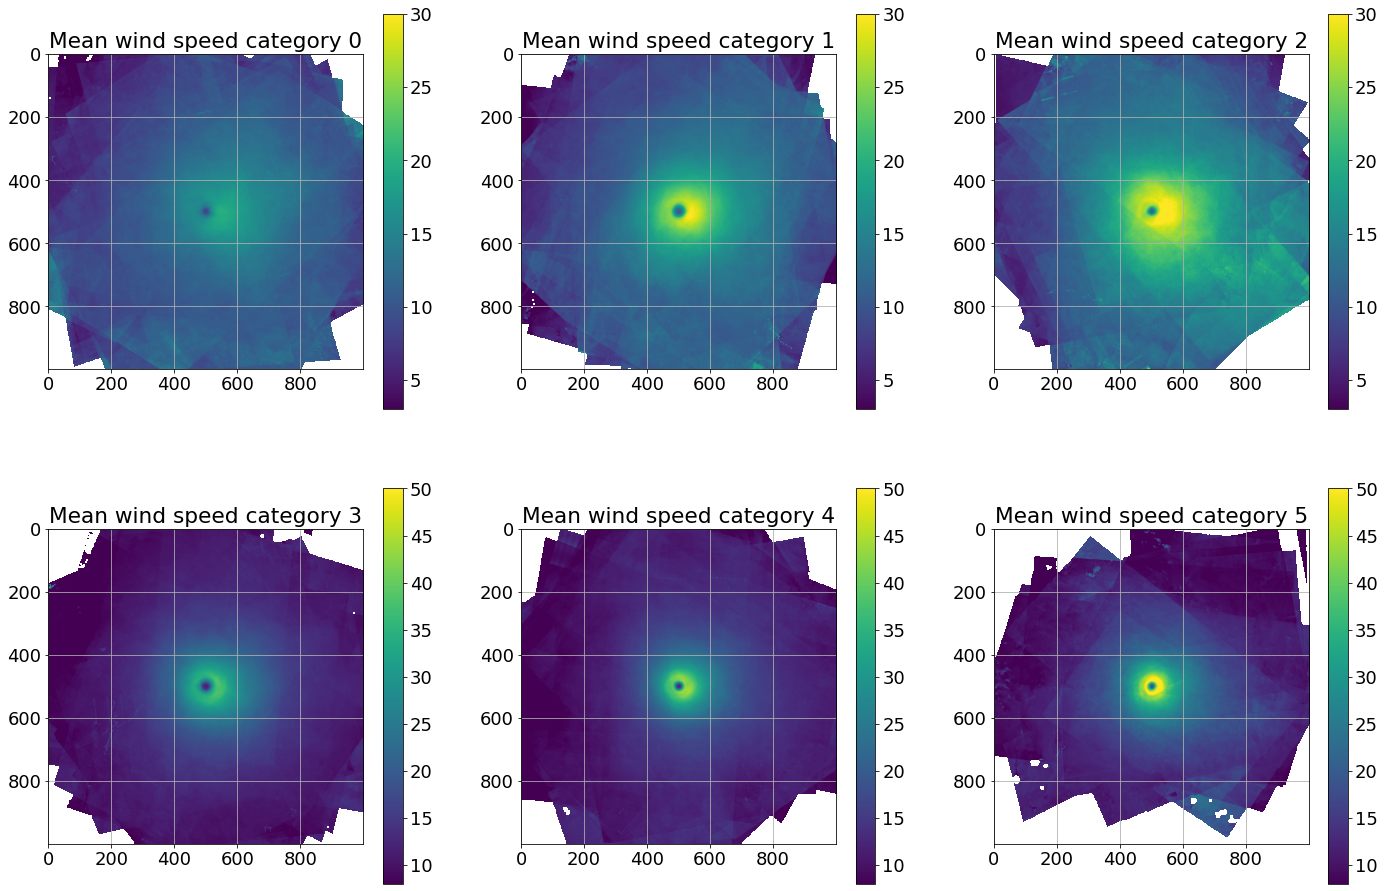

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Mean in cartesian system without normalisation.
fig, axs = plt.subplots(2,3,figsize=(24, 16))
for i in range(6):
  if i<3 :
    vmin,vmax=3,30 
  else :
    vmin,vmax=8,50
    
  im=axs[i//3,i%3].imshow(WS[i],vmin=vmin,vmax=vmax)

  plt.colorbar(im, ax=axs[i//3,i%3])

  axs[i//3,i%3].set_title(f"Mean wind speed category {i}")
  axs[i//3,i%3].grid(True)

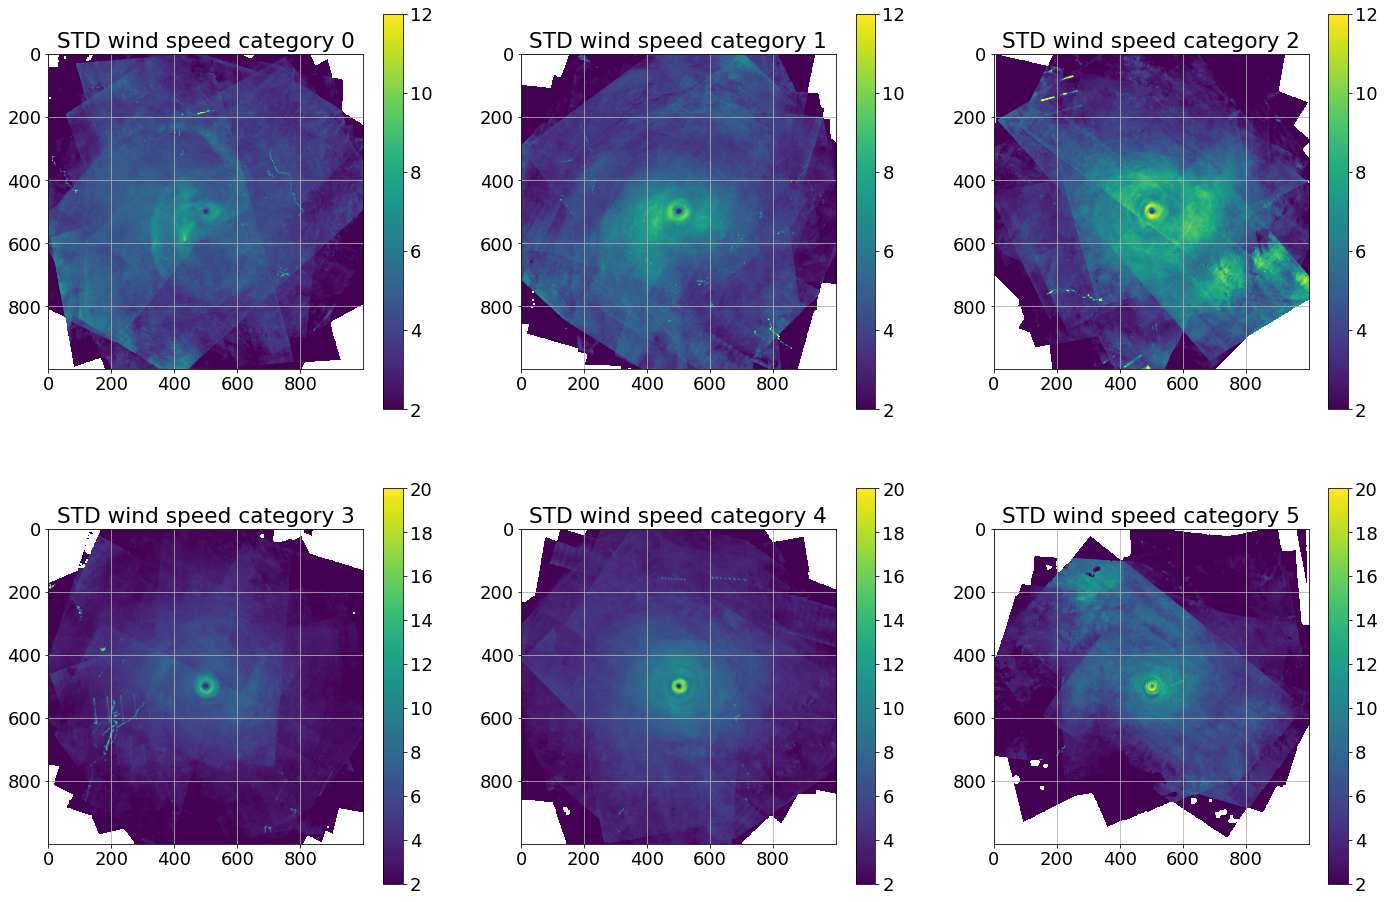

In [ ]:
# STD in cartesian system without normalisation.
fig, axs = plt.subplots(2,3,figsize=(24, 16))
for i in range(6):
  
  if i<3 :
    vmin,vmax=2,12 
  else :
    vmin,vmax=2,20
    
  im=axs[i//3,i%3].imshow(WS_std[i],vmin=vmin,vmax=vmax)

  plt.colorbar(im, ax=axs[i//3,i%3])

  axs[i//3,i%3].set_title(f"STD wind speed category {i}")
  axs[i//3,i%3].grid(True)

## *Second method: polar projection*

### Justification polar *projection*





#### Comparison of Two cyclones

In [ ]:
ds=ds_all[["wind_speed","cat","storm_name","storm_id"]]
ds=ds.assign(r=lambda ds: np.round(np.sqrt(ds.x**2+ds.y**2),0))
ds=ds.assign(theta=lambda ds: np.arctan2(ds.y,ds.x))
ds

<xarray.Dataset>
Dimensions:     (time: 341, x: 1000, y: 1000)
Coordinates:
  * time        (time) datetime64[ns] 2012-08-14T01:39:56 ... 2021-04-20T09:4...
  * x           (x) int64 -499000 -498000 -497000 ... 498000 499000 500000
  * y           (y) int64 -499000 -498000 -497000 ... 498000 499000 500000
Data variables:
    wind_speed  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    cat         (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    storm_name  (time) object dask.array<chunksize=(341,), meta=np.ndarray>
    storm_id    (time) object dask.array<chunksize=(341,), meta=np.ndarray>
    r           (x, y) float64 7.057e+05 7.05e+05 ... 7.064e+05 7.071e+05
    theta       (y, x) float64 -2.356 -2.355 -2.354 ... 0.7874 0.7864 0.7854

In [ ]:
# Two cyclones of the same category can be really different.
for cat, ds_cat in ds.groupby('cat'):
  if cat==3:
    ds_cat_3=ds_cat
    

In [ ]:
r_grid=np.linspace(0,rmax,nb_points)
ls_r_vmax=[]
for time_index in tqdm(range(len(ds_cat_3.time))):
      dsi=ds_cat_3.isel(time=time_index)
      ls_r_vmax.append(r_grid[np.nanargmax(mean_wind(dsi,rmax,nb_points))])
ls_r_vmax==np.array(ls_r_vmax)
maxi=np.nanargmax(ls_r_vmax) #We take the cyclone of category 3 with the biggest eye and the one with the smallest one in our dataset.
mini=np.nanargmin(ls_r_vmax)

  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


Text(0, 0.5, 'y (m)')

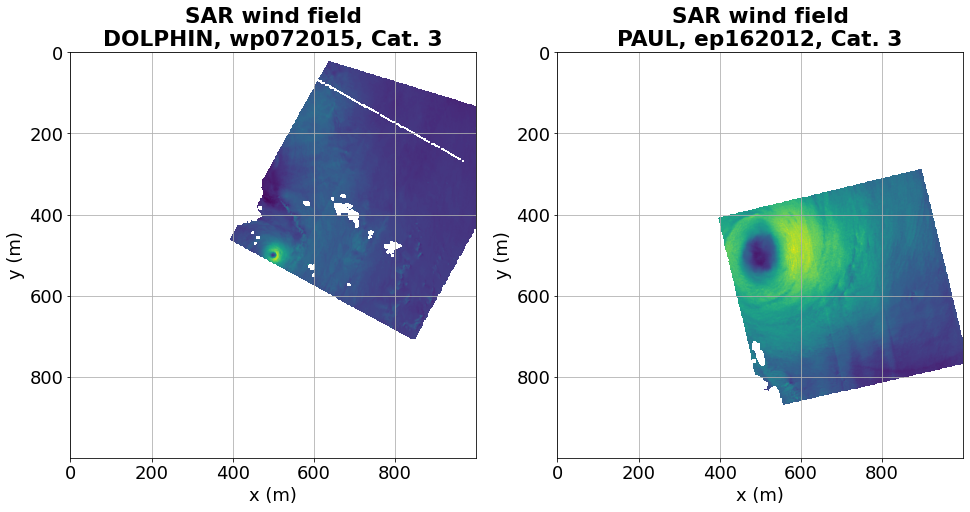

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 16))
im1=ax1.imshow(ds_cat_3.isel(time=27).wind_speed.values)
im2=ax2.imshow(ds_cat_3.isel(time=2).wind_speed.values)
#plt.colorbar(im1, ax=ax1)
name1 = ds_all.isel(time=27)['storm_name'].values
tcId1 = ds_all.isel(time=27)['storm_id'].values

name2 = ds_all.isel(time=2)['storm_name'].values
tcId2 = ds_all.isel(time=2)['storm_id'].values

ax1.set_title('SAR wind field\n%s, %s, Cat. 3'%(name1, tcId1), weight='bold')
ax1.grid(True)
ax1.set_xlabel('x (m)');ax1.set_ylabel('y (m)')


ax2.set_title('SAR wind field\n%s, %s, Cat. 3'%(name2, tcId2), weight='bold')
ax2.grid(True)
ax2.set_xlabel('x (m)');ax2.set_ylabel('y (m)')


#### Histograms

In [ ]:
RMAX=rVmax(ds,rmax)

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
100%|██████████| 6/6 [04:41<00:00, 46.92s/it]


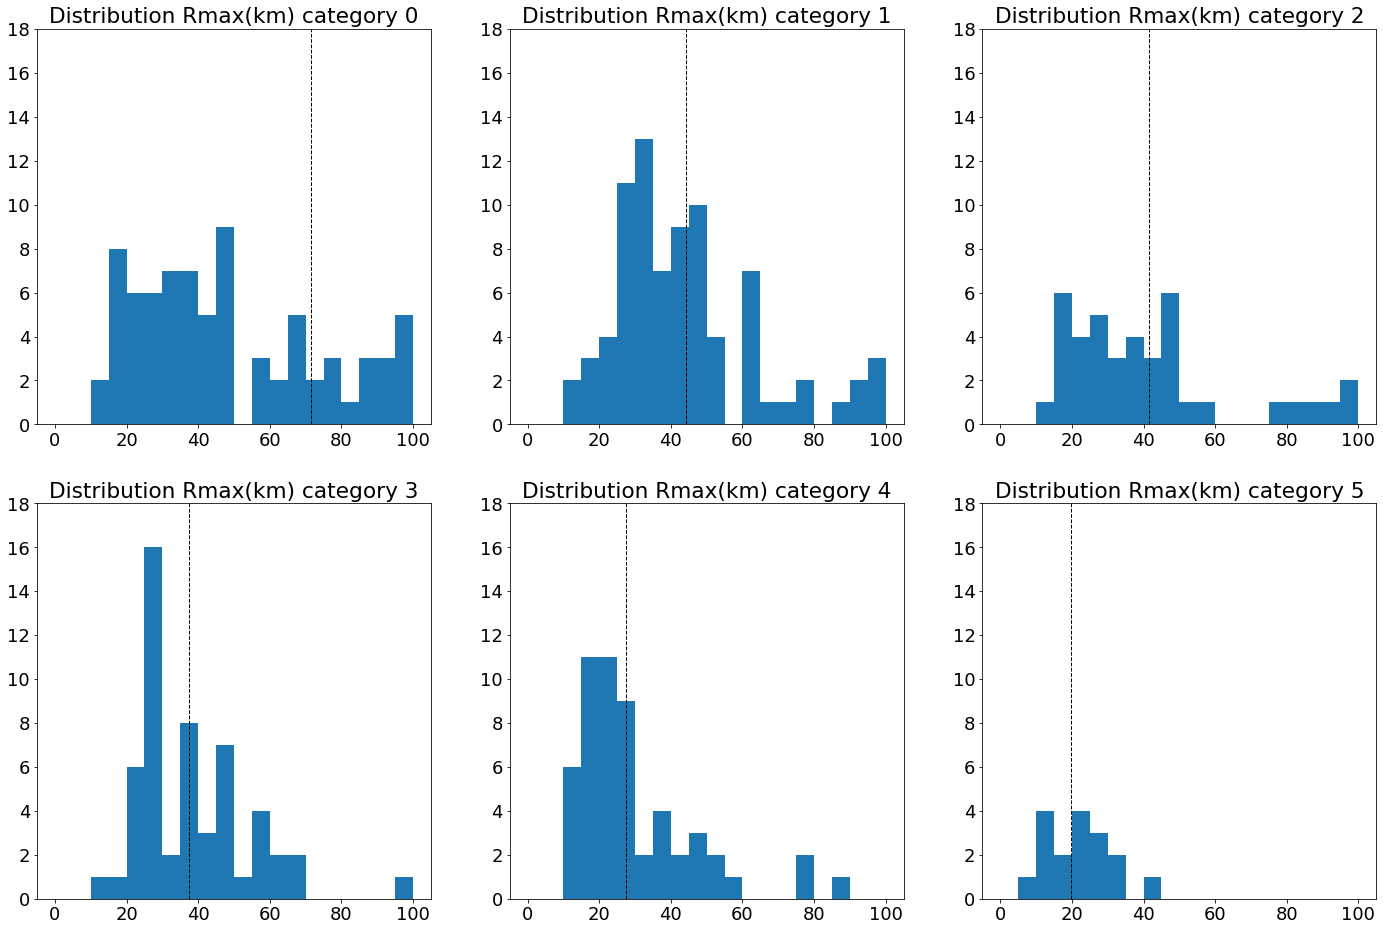

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(24, 16))
for i in range(6):
  im=axs[i//3,i%3].hist(RMAX[i],bins=20,range=(0, 100))
  axs[i//3,i%3].set_title(f"Distribution Rmax(km) category {i}")
  axs[i//3,i%3].set_ylim([0,18])
  axs[i//3,i%3].axvline(np.nanmean(np.mean(RMAX[i])), color='k', linestyle='dashed', linewidth=1)
  

##### KDE

In [ ]:
import pandas as pd

Text(0.5, 0, 'Distance to the center (km)')

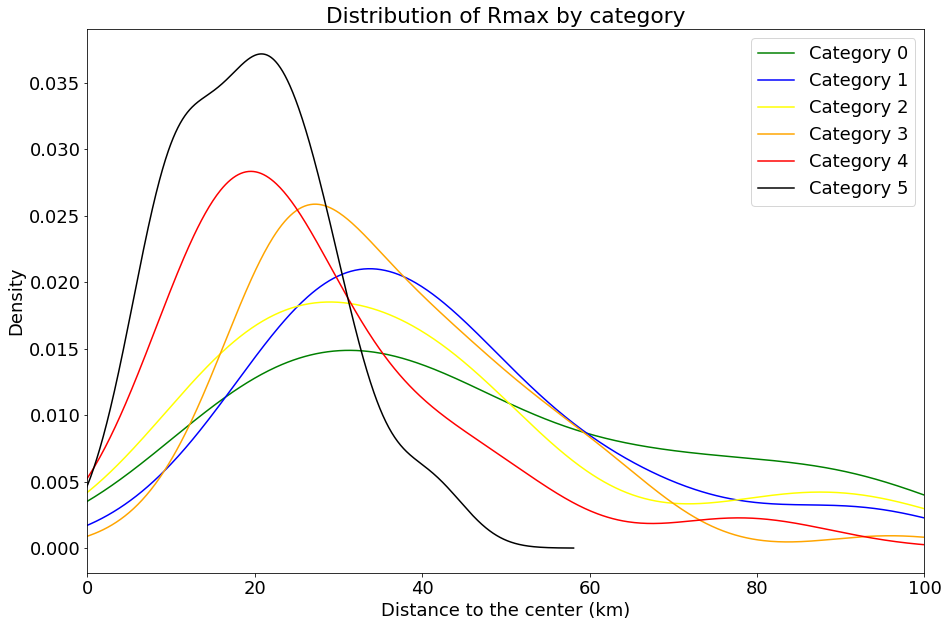

In [ ]:
col={0:"green",1:"blue",2:"yellow",3:"orange",4:"red",5:"black"}
for i in range(6):
  s = pd.Series(RMAX[i][RMAX[i]<100])
  s.plot.kde(bw_method=0.5,label='Category '+str(i),c=col[i])
  plt.xlim([0,100])
  plt.legend()
#plt.hist(RMAX[1],density=True,bins=20,range=(0, 100))
plt.title("Distribution of Rmax by category")
plt.xlabel("Distance to the center (km)")

### Normalisation

In [ ]:
ds_mini=ds

In [ ]:
from scipy.interpolate import griddata

rmax=500000
nb_points=100
nb_theta=100

def mean_wind(ds,rmax,nb_points):
  r=np.ravel(ds["r"].values)
  theta=np.rad2deg(np.ravel(ds["theta"].values))
  wind=np.ravel(ds["wind_speed"].values)
  r_grid=np.linspace(0,rmax,nb_points)
  theta_grid=np.arange(nb_theta)
  R,THETA=np.meshgrid(r_grid,theta_grid)
  wind_grid=griddata((r,theta),wind,(R,THETA),method="nearest")
  mean=np.nanmean(wind_grid,axis=0)
  return mean

def normalisation(ds,rmax):
  ls_ds=[]
  for time_index in tqdm(range(len(ds.time))):
    dsi=ds.isel(time=time_index)
    ls_ds.append(normalisation_unique(dsi,rmax))
  return xr.concat(ls_ds,dim='time')

    

def normalisation_unique(ds,rmax):
  
  r_grid=np.linspace(0,rmax,nb_points)
  r_vmax=r_grid[np.nanargmax(mean_wind(ds,rmax,nb_points))]
  ds=ds.assign(r_reduce=lambda ds: ds.r/r_vmax)
  return ds

def rVmax(ds,rmax) :
  RMAX={}
  r_grid=np.linspace(0,rmax,nb_points)
  for cat, ds_cat in tqdm(ds.groupby('cat')):
    #print('Cat. %i ='%cat, ds_cat.dims['time'])
    ls_r_vmax=[]
    for time_index in range(len(ds_cat.time)):
      dsi=ds_cat.isel(time=time_index)
      ls_r_vmax.append(r_grid[np.nanargmax(mean_wind(dsi,rmax,nb_points))])
    RMAX[cat]=np.array(ls_r_vmax)/1000
  return RMAX



def plot_polar_reduce(ds):
  r=ds["r_reduce"].values
  theta=ds["theta"].values
  wind=ds["wind_speed"].values
  fig=plt.figure()
  ax=fig.add_subplot(111,polar=True)
  ax.pcolormesh(theta,r,wind)
  ax.grid(True)
  ax.plot(np.linspace(0,360),np.ones(50),c="red")
  ax.set_rmax(5)
  plt.show(fig)
  

def plot_polar(ds):
  r=ds["r"].values
  theta=ds["theta"].values
  wind=ds["wind_speed"].values
  fig=plt.figure()
  ax=fig.add_subplot(111,polar=True)
  ax.pcolormesh(theta,r,wind)
  ax.grid(True) 
  ax.set_rmax(300000) 
  plt.show(fig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Wind speed (m/s)')

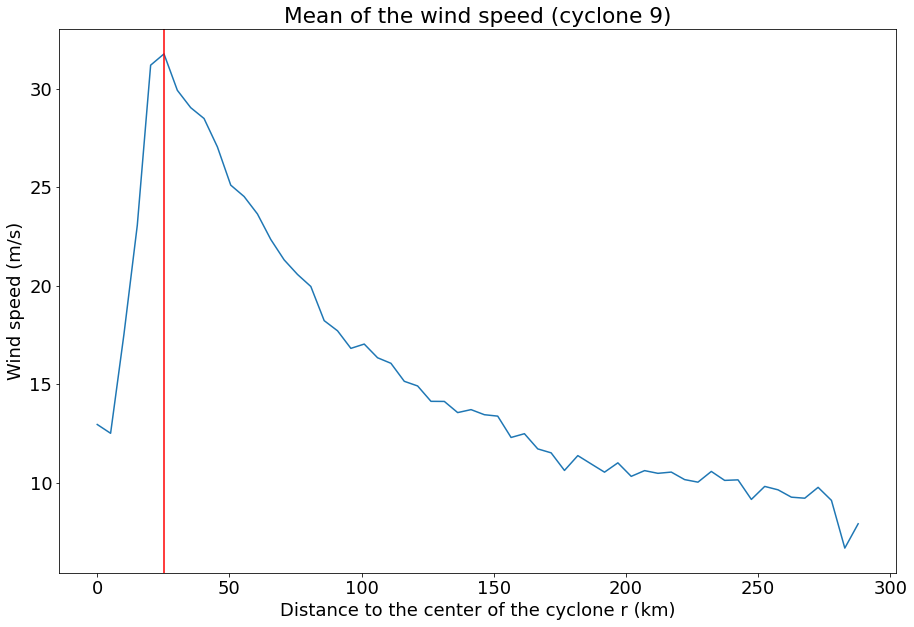

In [ ]:
abs=np.linspace(0,rmax/1000,nb_points)
ord=mean_wind(ds_mini.isel(time=9),rmax,nb_points)
plt.plot(abs,ord)
plt.axvline(x=abs[np.nanargmax(ord)],c='red')
plt.title("Mean of the wind speed (cyclone 9)")
plt.xlabel("Distance to the center of the cyclone r (km)")
plt.ylabel("Wind speed (m/s)")

In [ ]:
ds_mini_normalise=normalisation(ds_mini,rmax)

  0%|          | 0/341 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
100%|██████████| 341/341 [02:53<00:00,  1.97it/s]


r.shape=(1000, 1000)
theta.shape=(1000, 1000)
wind.shape=(1000, 1000)


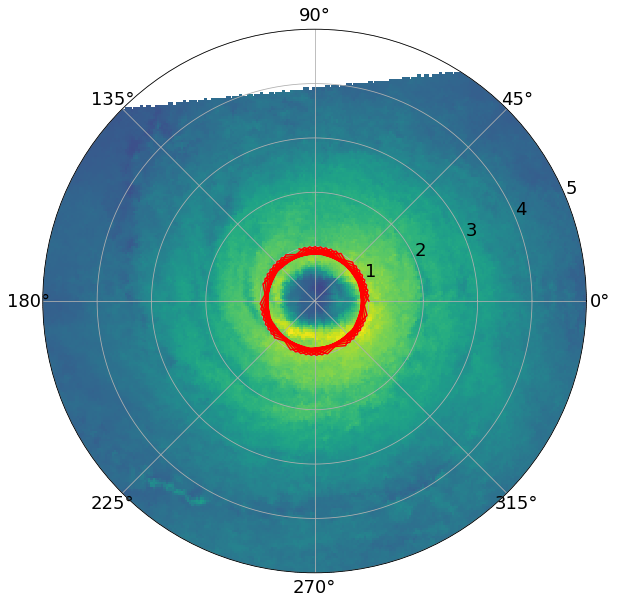

In [ ]:
plot_polar_reduce(ds_mini_normalise.isel(time=9))
#plot_polar(ds_mini.isel(time=9))

In [ ]:
# Creation of a new dataset in r* and theta with an interpolation.
ls_ds=[]
for time_index in tqdm(range(len(ds_mini_normalise.time))):
  if time_index!=82:
    ds_mini_normalise_i=ds_mini_normalise.isel(time=time_index)
    r=np.ravel(ds_mini_normalise_i["r_reduce"].values)
    theta=np.ravel(ds_mini_normalise_i["theta"].values)
    wind=np.ravel(ds_mini_normalise_i["wind_speed"].values)
    cat=np.ravel(ds_mini_normalise_i["cat"].values)
    time=np.ravel(ds_mini_normalise_i["time"].values)
    r_grid=np.linspace(0,5,nb_points)
    theta_grid=np.linspace(-np.pi,np.pi,nb_theta) #attention, betwen -pi and pi
    R,THETA=np.meshgrid(r_grid,theta_grid)
    wind_grid=griddata((r,theta),wind,(R,THETA),method="nearest")
    wind_grid=np.expand_dims(wind_grid,axis=0)
    ds_r_theta = xr.Dataset(
      data_vars=dict(
          wind_speed=(["time", "theta","r"],wind_grid),
          cat=(["time"], cat),
      ),
      coords=dict(
          r=r_grid,
          theta=theta_grid,
          time=time,
          
      )
    )
    ls_ds.append(ds_r_theta)
ds_mini_normalise_concat=xr.concat(ls_ds,dim='time')

100%|██████████| 341/341 [02:47<00:00,  2.04it/s]


In [ ]:
### GROUP DATASET BY CATEGORY
WS_reduce={}
for cat, ds_cat in tqdm(ds_mini_normalise_concat.groupby('cat')):
    WS_reduce[cat]=ds_cat.mean(dim="time",skipna=True)["wind_speed"].values
    #print('Cat. %i ='%cat, ds_cat.dims['time'])

100%|██████████| 6/6 [00:00<00:00, 110.81it/s]


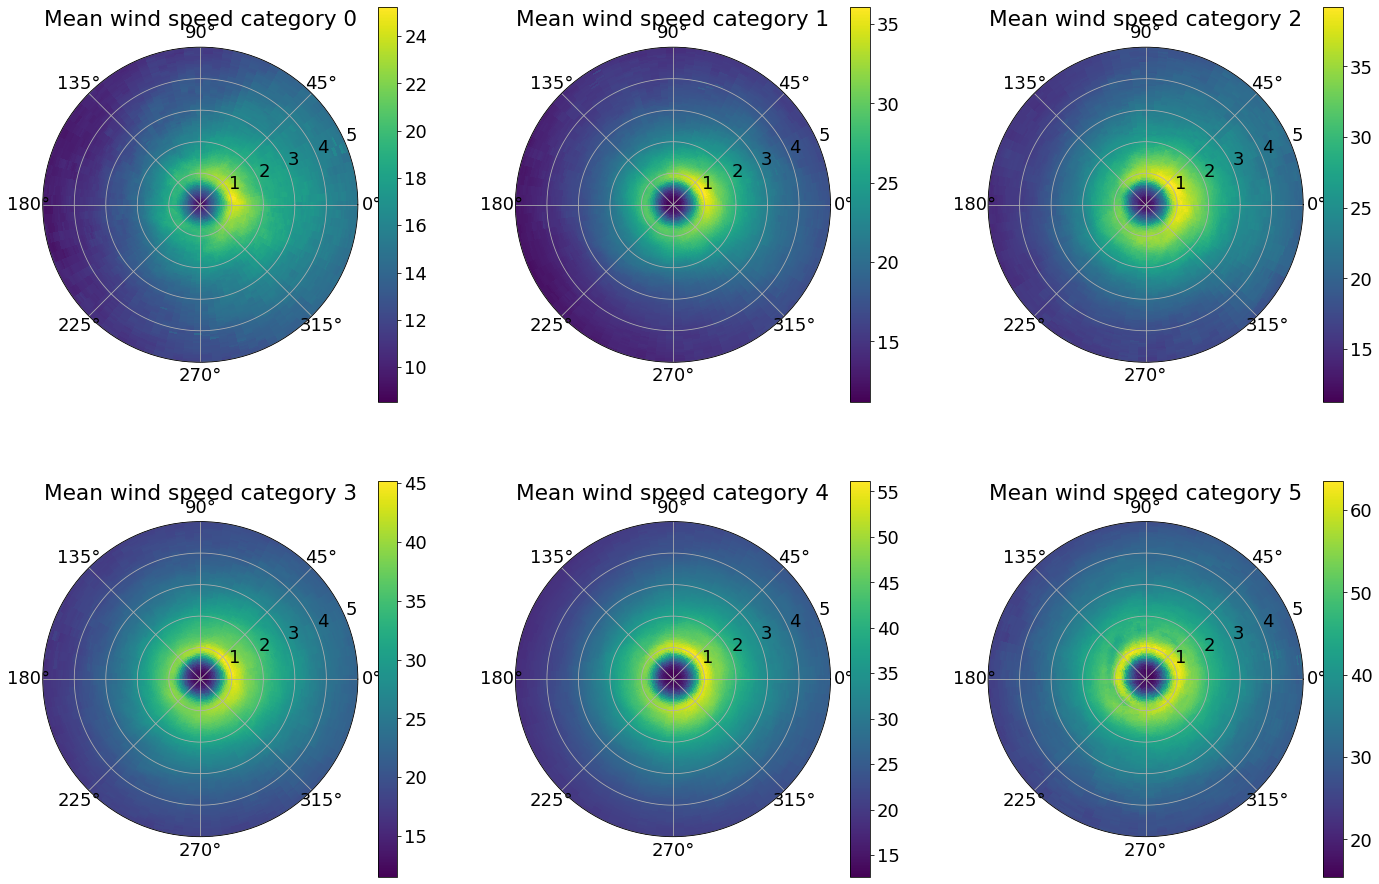

In [ ]:
r_grid=np.linspace(0,5,nb_points)
theta_grid=np.linspace(-np.pi,np.pi,nb_theta)
R,THETA=np.meshgrid(r_grid,theta_grid)

fig=plt.figure(figsize=(24,16))
axs={}
for i in range(6):
  
  axs[i]=fig.add_subplot(2,3,i+1,polar=True)
  quadmesh=axs[i].pcolormesh(THETA,R,WS_reduce[i])
  axs[i].set_title(f"Mean wind speed category {i}")
  axs[i].grid(True) 
  fig.colorbar(quadmesh,ax=axs[i])
  

plt.show(fig)



In [ ]:
### GROUP DATASET BY CATEGORY
WS_reduce_std={}
for cat, ds_cat in tqdm(ds_mini_normalise_concat.groupby('cat')):
    WS_reduce_std[cat]=ds_cat.std(dim="time",skipna=True)["wind_speed"].values
    #print('Cat. %i ='%cat_std, ds_cat.dims['time'])

100%|██████████| 6/6 [00:00<00:00, 158.11it/s]


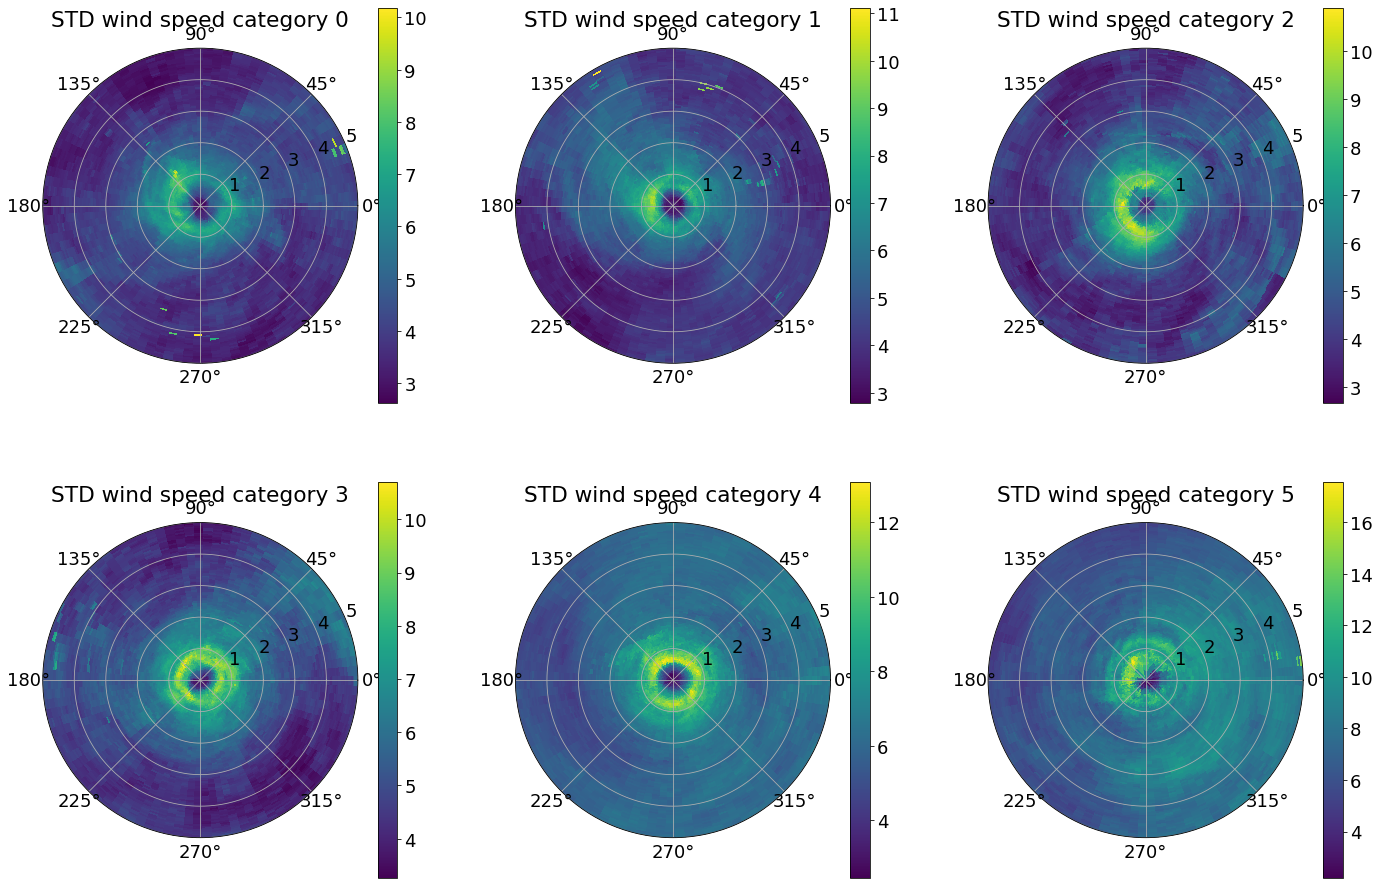

In [ ]:
r_grid=np.linspace(0,5,nb_points)
theta_grid=np.linspace(-np.pi,np.pi,nb_theta)
R,THETA=np.meshgrid(r_grid,theta_grid)

fig=plt.figure(figsize=(24,16))
axs={}
for i in range(6):
  
  axs[i]=fig.add_subplot(2,3,i+1,polar=True)
  quadmesh=axs[i].pcolormesh(THETA,R,WS_reduce_std[i])
  axs[i].set_title(f"STD wind speed category {i}")
  axs[i].grid(True) 
  fig.colorbar(quadmesh,ax=axs[i])
  

plt.show(fig)

